This notebook combines all features into one large model. 

In [1]:
model_name = "high_quality" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys


In [3]:
module_path = os.path.abspath(os.path.join('../..', 'utils'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

from ml_tools import add_weekends_holidays

d:\CS\summer_project\comp47360-group8\ml_pipeline\utils


In [4]:
df = pd.read_parquet('../../data_evaluation/taxi_trip_data/all_tlc_data_cleaned.parquet')
df.rename({'passenger_count':'busyness', 'location':'item_id', 'datetime': 'timestamp'},axis=1, inplace=True)
print(df.columns)

Index(['timestamp', 'item_id', 'busyness'], dtype='object')


In [5]:
df['day'] = df['timestamp'].dt.day_name().str.lower()
df['hour'] = df['timestamp'].dt.hour

In [6]:
df.shape

(7319643, 5)

In [7]:
df.head()

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0


In [8]:
df_open = pd.read_csv("../../data_preparation/taxi_location_num_businesses_open/taxi_location_num_businesses_open.csv")
df_open.rename({'location':'item_id'},axis=1, inplace=True)


In [9]:
df

,timestamp,item_id,busyness,day,hour
0,2021-01-01,3,132,friday,0
1,2021-01-01,4,234,friday,0
2,2021-01-01,5,19,friday,0
3,2021-01-01,6,37,friday,0
4,2021-01-01,7,493,friday,0
...,...,...,...,...,...
7319638,2024-04-01,107,1,monday,0
7319639,2024-04-01,163,6,monday,0
7319640,2024-04-01,225,1,monday,0
7319641,2024-04-01,226,1,monday,0


In [10]:
df = df.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])

In [11]:
df.fillna({'alcohol':0, 'food':0, 'leisure':0}, inplace=True)

In [12]:
df.drop(['day', 'hour'], axis=1, inplace=True)

In [13]:
df.head()

,timestamp,item_id,busyness,food,alcohol,leisure
0,2021-01-01,3,132,0.0,0.0,0.0
1,2021-01-01,4,234,0.0,0.0,0.0
2,2021-01-01,5,19,0.0,0.0,0.0
3,2021-01-01,6,37,0.0,0.0,0.0
4,2021-01-01,7,493,0.0,0.0,0.0


In [14]:
df_wth = pd.read_csv("../../data_evaluation/weather_meteostat/meteostat_weather.csv")
df_wth.rename({'time':'timestamp'}, axis=1,inplace=True)
df_wth['timestamp'] = df_wth['timestamp'].astype('datetime64[us]')
df_wth['timestamp'] = pd.to_datetime(df_wth['timestamp'])
df_wth['coco'] = df_wth['coco'].astype('category')
df_wth.sort_values(by=['timestamp'])
df = df.join(df_wth.set_index('timestamp'), on='timestamp', how='left')

In [15]:
static_features_df = pd.read_csv("../../data_evaluation/taxi_trip_data/taxi_zone_lookup.csv")
static_features_df.rename({'LocationID': 'item_id'}, axis=1, inplace=True)

In [16]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="item_id",
    timestamp_column="timestamp",
    static_features_df = static_features_df
)

In [17]:
def add_num_places_open(data):
    timestamps = data.index.get_level_values("timestamp").to_series()
    data['day'] = timestamps.dt.day_name().str.lower().values
    data['hour'] = timestamps.dt.hour
    locations = data.index.get_level_values("item_id")
    
    

In [18]:
add_weekends_holidays(data)

In [19]:
data.head()

,,busyness,food,alcohol,leisure,temp,dwpt,rhum,prcp,pres,coco,weekend,holiday
item_id,timestamp,,,,,,,,,,,,
3,2021-01-01,132,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
4,2021-01-01,234,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
5,2021-01-01,19,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
6,2021-01-01,37,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0
7,2021-01-01,493,0.0,0.0,0.0,4.0,-4.0,56.0,0.0,1026.3,4.0,0.0,1.0


In [20]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [21]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name,
    known_covariates_names=['food', 'alcohol', 'leisure', 'weekend', 'holiday', 'temp', 'dwpt', 'rhum', 'prcp', 'pres', 'coco']
)
print('we made the predictor')

we made the predictor


In [22]:
predictions = predictor.fit(train_data,
                                presets="high_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'high_quality_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       5.89 GB / 15.90 GB (37.0%)
Disk Space Avail:   2124.69 GB / 2794.50 GB (76.0%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'default',
 'known_covariates_names': ['food',
                            'alcohol',
                            'leisure',
                            'weekend',
                            'holiday',
                            'temp',
                            'dwpt',
                            'rhum',
                            'prcp',
                            'pres',
                            'coco'],
 'num_val_windows

In [23]:
print(predictor.leaderboard())

                    model  score_val  pred_time_val  fit_time_marginal  \
0        WeightedEnsemble  -0.845314    4750.912540         122.337114   
1                PatchTST  -0.901157      16.015715         202.458535   
2           Chronos[base]  -1.079689    3842.181981           4.638805   
3        RecursiveTabular  -1.182713     707.010483        1028.061975   
4                    NPTS  -1.201048    2607.793031           6.864380   
5                  DeepAR  -1.264931      87.583443         368.421311   
6               AutoARIMA  -1.311993    1304.402613           7.817136   
7           SeasonalNaive  -1.339581       3.930524           6.896356   
8           DirectTabular  -1.377105      98.120918         280.852162   
9              CrostonSBA  -2.085151      16.325305           8.001267   
10  DynamicOptimizedTheta  -2.239275      69.764357           7.890764   
11                AutoETS  -9.005625     188.139215           7.764626   

    fit_order  
0          12  
1    

In [24]:
future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=prediction_length, freq='H')
future_timestamps = future_index.get_level_values("timestamp").to_series()


c:\Users\Daniel\miniconda3\envs\comp47360_autogluon\lib\site-packages\autogluon\timeseries\utils\forecast.py:34: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset = pd.tseries.frequencies.to_offset(freq)


In [25]:
known_covariates = pd.DataFrame(index=future_index)

In [26]:
known_covariates

Empty DataFrame
Columns: []
Index: [(3, 2024-01-01 23:00:00), (3, 2024-01-02 00:00:00), (3, 2024-01-02 01:00:00), (3, 2024-01-02 02:00:00), (3, 2024-01-02 03:00:00), (3, 2024-01-02 04:00:00), (3, 2024-01-02 05:00:00), (3, 2024-01-02 06:00:00), (3, 2024-01-02 07:00:00), (3, 2024-01-02 08:00:00), (3, 2024-01-02 09:00:00), (3, 2024-01-02 10:00:00), (3, 2024-01-02 11:00:00), (3, 2024-01-02 12:00:00), (3, 2024-01-02 13:00:00), (3, 2024-01-02 14:00:00), (3, 2024-01-02 15:00:00), (3, 2024-01-02 16:00:00), (3, 2024-01-02 17:00:00), (3, 2024-01-02 18:00:00), (3, 2024-01-02 19:00:00), (3, 2024-01-02 20:00:00), (3, 2024-01-02 21:00:00), (3, 2024-01-02 22:00:00), (3, 2024-01-02 23:00:00), (3, 2024-01-03 00:00:00), (3, 2024-01-03 01:00:00), (3, 2024-01-03 02:00:00), (3, 2024-01-03 03:00:00), (3, 2024-01-03 04:00:00), (3, 2024-01-03 05:00:00), (3, 2024-01-03 06:00:00), (3, 2024-01-03 07:00:00), (3, 2024-01-03 08:00:00), (3, 2024-01-03 09:00:00), (3, 2024-01-03 10:00:00), (3, 2024-01-03 11:00:00), (3, 2024-01-03 12:00:00), (3, 2024-01-03 13:00:00), (3, 2024-01-03 14:00:00), (3, 2024-01-03 15:00:00), (3, 2024-01-03 16:00:00), (3, 2024-01-03 17:00:00), (3, 2024-01-03 18:00:00), (3, 2024-01-03 19:00:00), (3, 2024-01-03 20:00:00), (3, 2024-01-03 21:00:00), (3, 2024-01-03 22:00:00), (3, 2024-01-03 23:00:00), (3, 2024-01-04 00:00:00), (3, 2024-01-04 01:00:00), (3, 2024-01-04 02:00:00), (3, 2024-01-04 03:00:00), (3, 2024-01-04 04:00:00), (3, 2024-01-04 05:00:00), (3, 2024-01-04 06:00:00), (3, 2024-01-04 07:00:00), (3, 2024-01-04 08:00:00), (3, 2024-01-04 09:00:00), (3, 2024-01-04 10:00:00), (3, 2024-01-04 11:00:00), (3, 2024-01-04 12:00:00), (3, 2024-01-04 13:00:00), (3, 2024-01-04 14:00:00), (3, 2024-01-04 15:00:00), (3, 2024-01-04 16:00:00), (3, 2024-01-04 17:00:00), (3, 2024-01-04 18:00:00), (3, 2024-01-04 19:00:00), (3, 2024-01-04 20:00:00), (3, 2024-01-04 21:00:00), (3, 2024-01-04 22:00:00), (3, 2024-01-04 23:00:00), (3, 2024-01-05 00:00:00), (3, 2024-01-05 01:00:00), (3, 2024-01-05 02:00:00), (3, 2024-01-05 03:00:00), (3, 2024-01-05 04:00:00), (3, 2024-01-05 05:00:00), (3, 2024-01-05 06:00:00), (3, 2024-01-05 07:00:00), (3, 2024-01-05 08:00:00), (3, 2024-01-05 09:00:00), (3, 2024-01-05 10:00:00), (3, 2024-01-05 11:00:00), (3, 2024-01-05 12:00:00), (3, 2024-01-05 13:00:00), (3, 2024-01-05 14:00:00), (3, 2024-01-05 15:00:00), (3, 2024-01-05 16:00:00), (3, 2024-01-05 17:00:00), (3, 2024-01-05 18:00:00), (3, 2024-01-05 19:00:00), (3, 2024-01-05 20:00:00), (3, 2024-01-05 21:00:00), (3, 2024-01-05 22:00:00), (3, 2024-01-05 23:00:00), (3, 2024-01-06 00:00:00), (3, 2024-01-06 01:00:00), (3, 2024-01-06 02:00:00), ...]

[563760 rows x 0 columns]

In [27]:
future_timestamps.dt.hour.to_list()

[23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 0,
 

In [28]:
known_covariates['hour'] = future_timestamps.dt.hour.to_list()

In [29]:
known_covariates['day'] = future_timestamps.dt.day_name().str.lower().values
known_covariates['hour'] = future_timestamps.dt.hour.to_list()
known_covariates = known_covariates.join(df_open.set_index(['day', 'hour', 'item_id']), on=['day', 'hour', 'item_id'])
known_covariates = known_covariates.join(df_wth.set_index("timestamp"), on='timestamp', how='left')
add_weekends_holidays(known_covariates)

In [30]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)

print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Trying to fill missing values in an unsorted dataframe. It is highly recommended to call `ts_df.sort_index()` before calling `ts_df.fill_missing_values()`
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


                                  mean        0.1        0.2        0.3  \
item_id timestamp                                                         
3       2024-01-01 23:00:00  90.704350  71.903157  77.316837  83.789357   
        2024-01-02 00:00:00  69.711952  49.975968  56.764429  61.640867   
        2024-01-02 01:00:00  53.084529  29.765468  37.201219  42.935020   
        2024-01-02 02:00:00  46.861302  22.296158  30.556731  36.438982   
        2024-01-02 03:00:00  40.243760  18.523944  26.057103  31.335229   
...                                ...        ...        ...        ...   
110     2022-04-23 13:00:00   1.136429  -5.319341  -3.081958  -1.485378   
        2022-04-23 14:00:00   1.151186  -5.367336  -3.103026  -1.492610   
        2022-04-23 15:00:00   1.215116  -5.307984  -3.040857  -1.430432   
        2022-04-23 16:00:00   1.278082  -5.316372  -3.016451  -1.387974   
        2022-04-23 17:00:00   1.309741  -5.287647  -2.987392  -1.358365   

                        

data with frequency 'None' has been resampled to frequency 'h'.


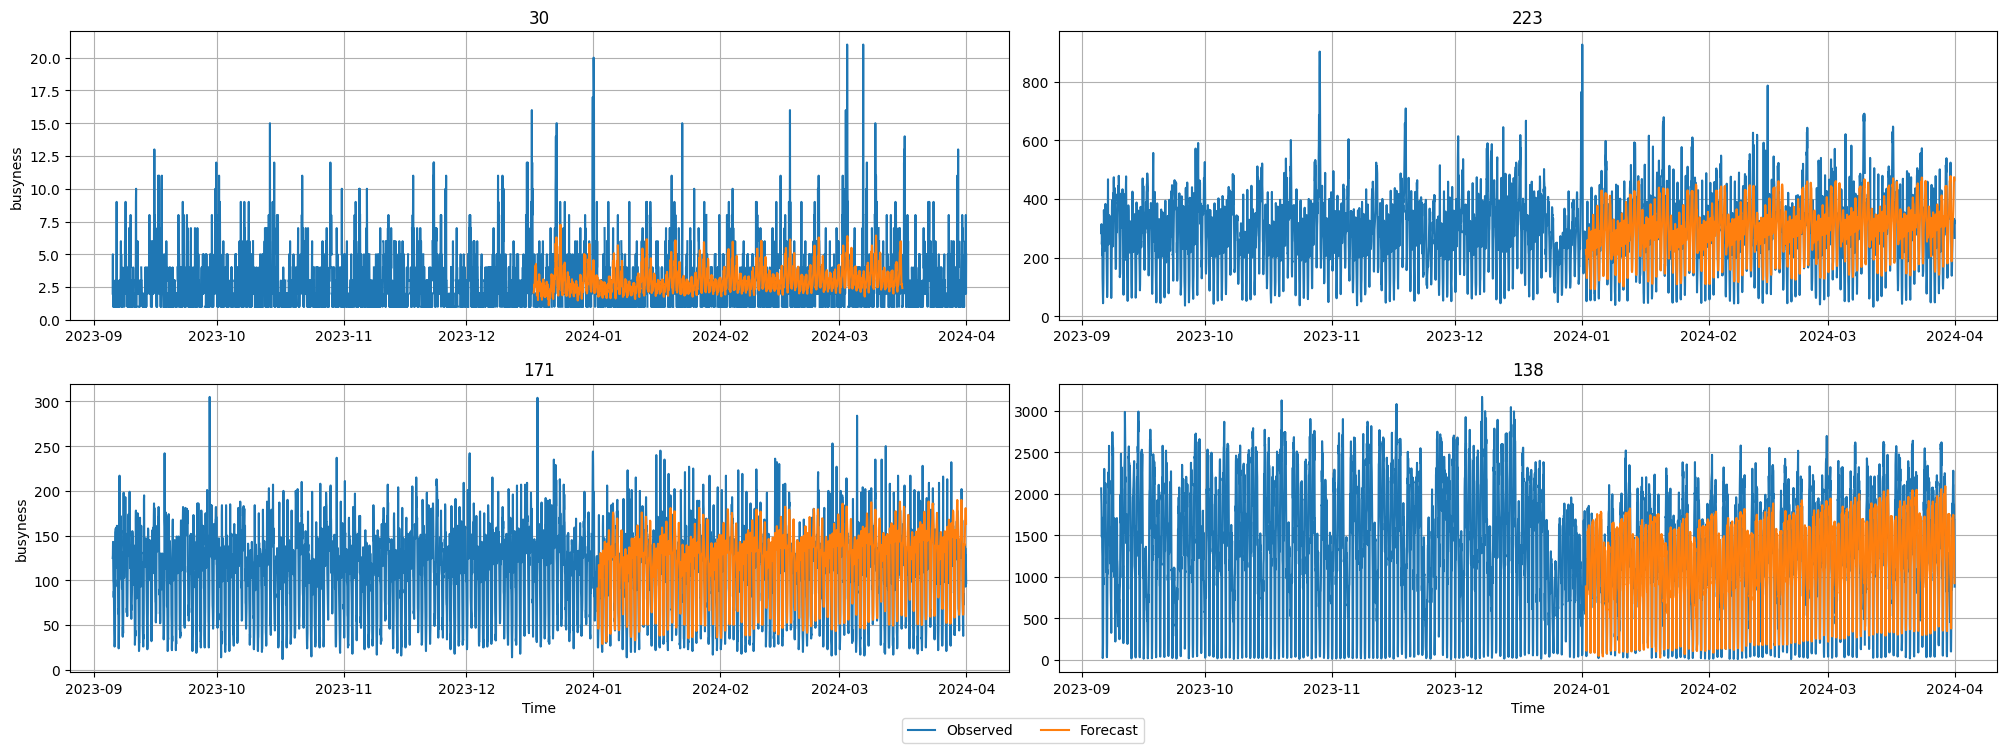

In [31]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=4)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


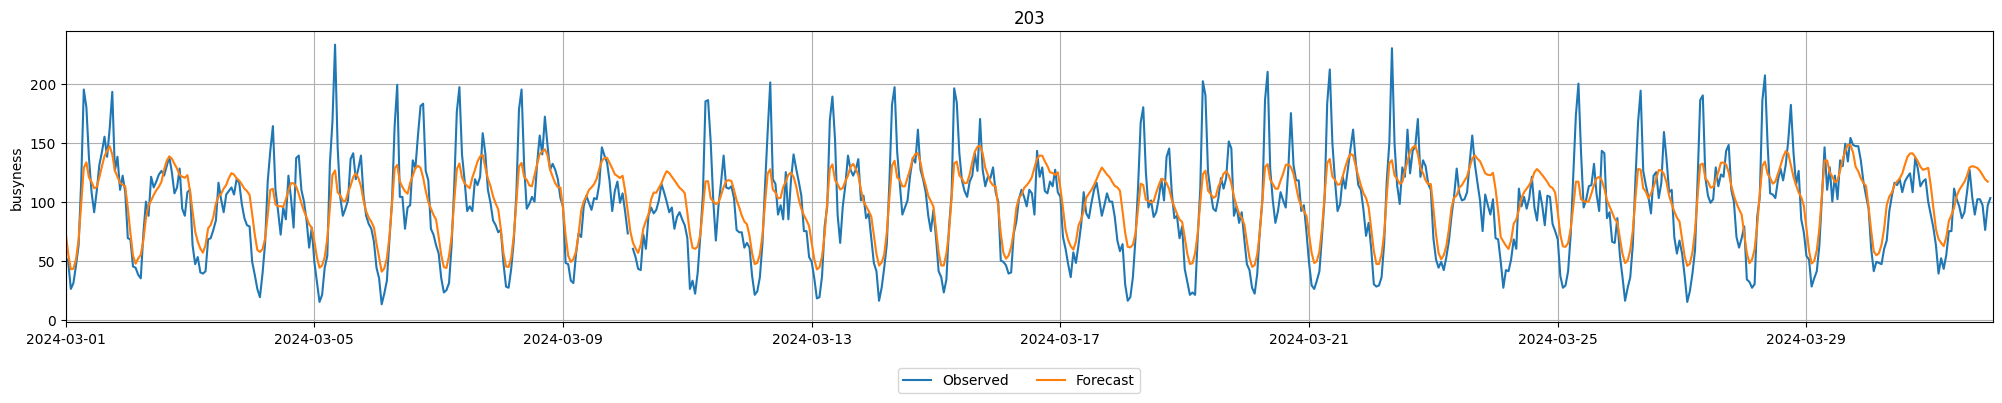

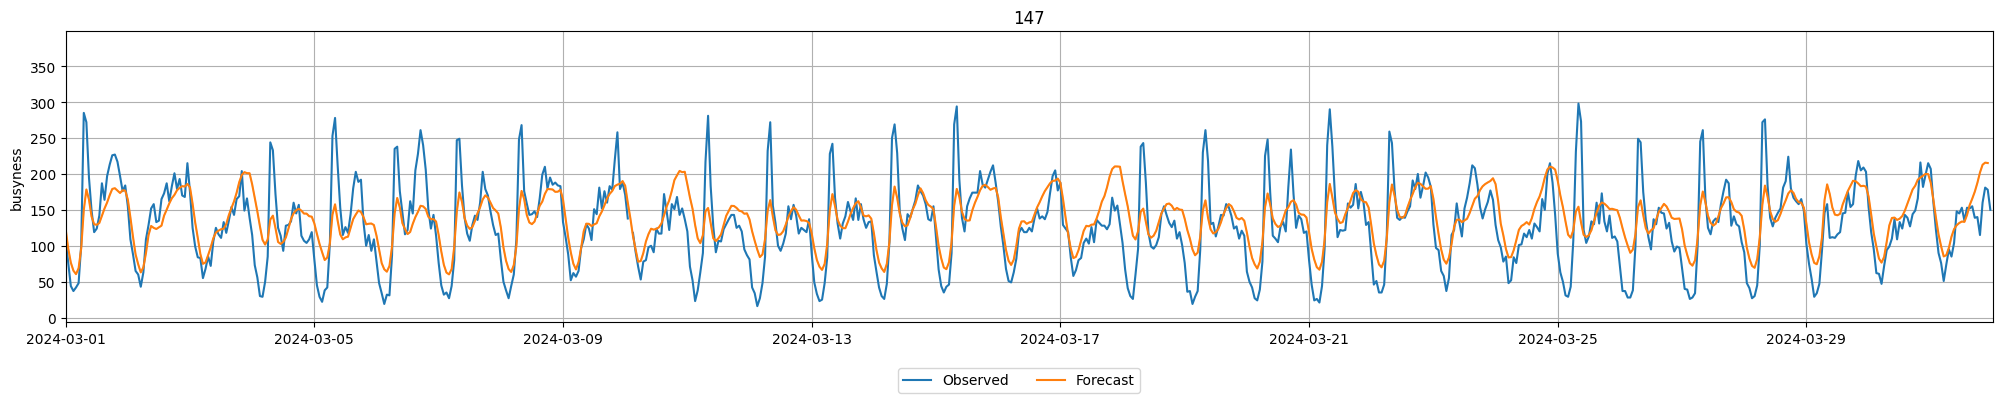

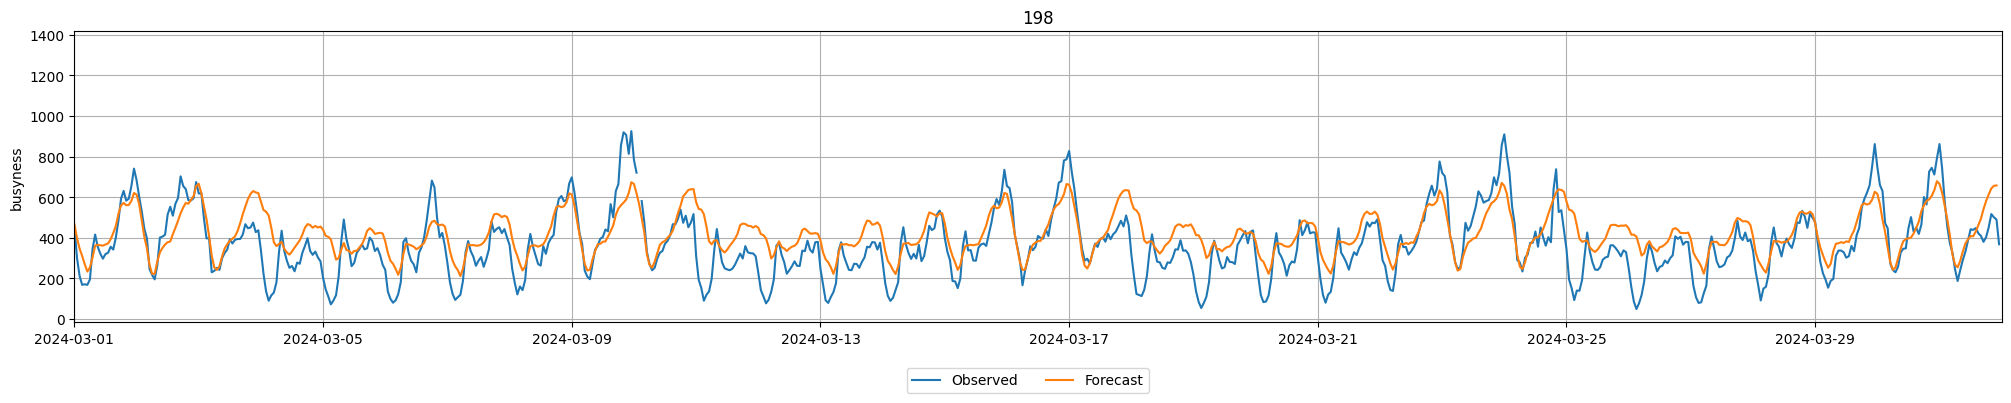

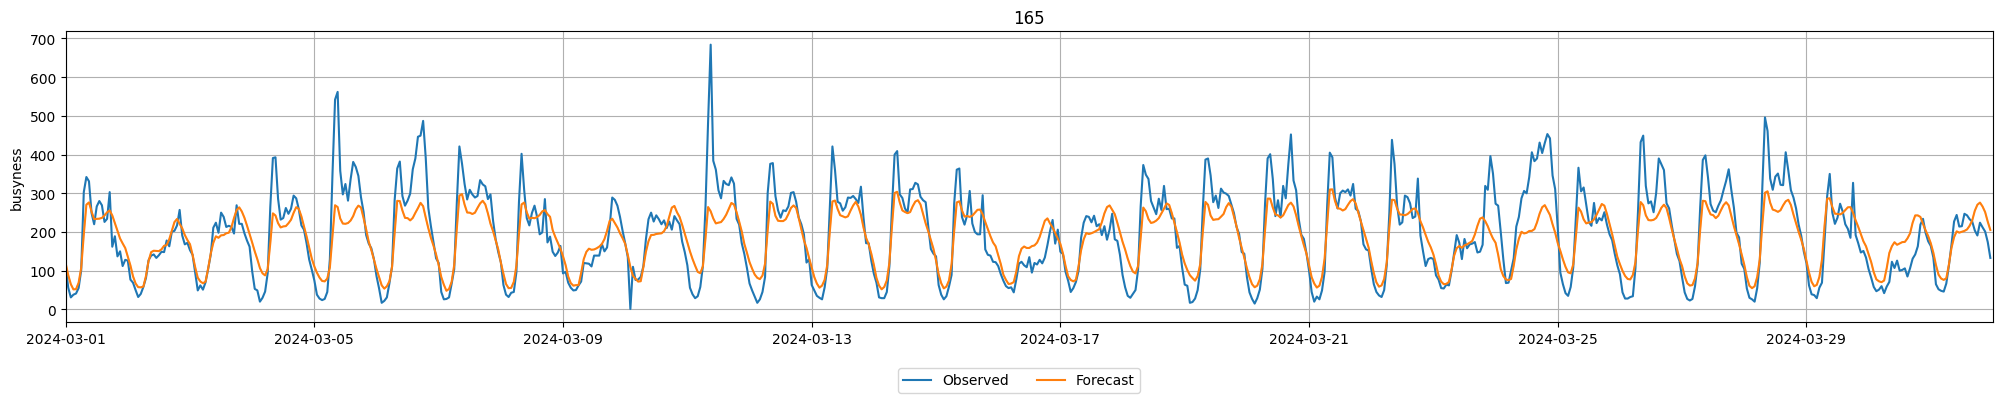

In [32]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
item_ids = [203, 147, 198, 165]
for id in item_ids:
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  item_ids=[id])
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [33]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'MASE': -1.1005690323877413}